# Analisis Spotify


## Imports

In [1]:
import pandas as pd
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt
#from pyvis.network import Network

## Lectura de los datos

In [2]:
df=pd.read_csv('../data/data.csv')

def is_duo(x):
    arts=ast.literal_eval(x)
    if len(arts)>1:
        return True
    else:
        return False
    
#Marcamos aquellas canciones que sean colaboraciones    
df['is_colab']=df['artists'].apply(lambda x:is_duo(x))
#Seleccionamos las colabs y de popularidad mayor, por disminuir el dataset
df=df[(df.is_colab==True) & (df.popularity>75)].drop(['id','mode','is_colab'],axis=1)

## Procesamiento

In [3]:
df.shape

(470, 17)

In [4]:
def get_artist_list(lista):
    res=set()
    for x in lista:
        arts=ast.literal_eval(x)
        for i in arts:
            res.add(i)
    return list(res)

def look_up(artist,df):
    res=list()
    for ind in df.index:
        d = list(df.loc[ind])
        if (artist in ast.literal_eval(d[1])):
            del d[1],d[6],d[8],d[9]
            res.append(d)
    return res

def create_nodes_meta(df):
    lista_artistas=get_artist_list(df.artists)
    new_df=pd.DataFrame(lista_artistas)
    res=list()
    for artist_x in lista_artistas:
        a_data=look_up(artist_x,df)
        a_means= np.nanmean(a_data,axis=0)
        data=np.concatenate(([artist_x],a_means))
        res.append(data)
    new_df=pd.DataFrame(res)
    new_df.columns=['artist','acousticness', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'liveness', 'loudness',
       'popularity', 'speechiness', 'tempo', 'valence',
       'year']
    return new_df
    
df_artist=df.copy()
df_artist=create_nodes_meta(df_artist)

In [5]:
df_artist

,artist,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,year
0,Nicki Minaj,0.20999999999999996,0.735,205585.33333333334,0.7726666666666667,0.3333333333333333,4.466666666666667e-05,0.20813333333333336,-3.5196666666666663,80.33333333333333,0.166,116.39233333333334,0.7023333333333333,2016.6666666666667
1,Michael Bublé,0.647,0.5529999999999999,166147.0,0.476,0.0,0.0,0.281,-8.869,76.0,0.0649,113.401,0.5579999999999999,2014.0
2,XXXTENTACION,0.021766666666666667,0.7376666666666667,185350.66666666666,0.5436666666666666,1.0,0.0010306666666666667,0.14966666666666664,-7.663,80.66666666666667,0.10493333333333334,130.36733333333333,0.32166666666666666,2017.3333333333333
3,Kane Brown,0.056799999999999996,0.6930000000000001,186615.0,0.6245,0.0,1.29e-05,0.35400000000000004,-5.334,79.0,0.05885,87.506,0.3805,2019.5
4,Logic,0.412,0.5609999999999999,246832.0,0.6799999999999999,1.0,0.0,0.42000000000000004,-6.082999999999999,77.5,0.18245,134.522,0.548,2016.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,Ariana Grande,0.16859090909090907,0.645,191559.45454545456,0.7214545454545455,0.2727272727272727,0.0,0.31596363636363634,-4.960181818181819,80.0909090909091,0.12567272727272727,130.37154545454547,0.5815999999999999,2018.7272727272727
514,Hailee Steinfeld,0.20584999999999995,0.696,178340.0,0.6619999999999999,0.0,0.0,0.09455,-4.196,77.0,0.05595,101.51599999999999,0.625,2016.5
515,Lil Baby,0.10258,0.8596,169303.0,0.5521,1.0,0.005650584,0.20455,-7.056,79.3,0.28666,132.6909,0.45309999999999995,2019.5
516,Skepta,0.22529999999999997,0.7796666666666666,180556.0,0.5736666666666667,1.0,0.02733066666666667,0.18896666666666662,-7.215333333333334,81.66666666666667,0.11266666666666665,117.28833333333336,0.25299999999999995,2019.3333333333333


## Creación del grafo

In [6]:
def add_nodes(df,graph):
    for ind in df.index:
        row=list(df.loc[ind])
        artist_x=row[0]
        graph.add_node(artist_x)
        for i,col in enumerate(df.columns):
            if col != 'artist':
                graph.nodes[artist_x][col]=row[i]
    return graph
    
def add_nodes_edges(df,df_artist,G):
    G=add_nodes(df_artist,G)
    for ind in df.index:
        artists=df.loc[ind]['artists'].strip('][').split(', ')
        artists=[art.replace("'","") for art in artists] 
        for i in range(len(artists)-1):
            G.add_edge(artists[i],artists[i+1])
            for column in df_artist.columns:
                if column != 'artist':
                    G[artists[i]][artists[i+1]][column]=df.loc[ind][column]
    return G

def add_attributes(G,d,name):
    for k,v in d.items():
        G.nodes[k][name]=v
    return G

G = nx.Graph()
G = add_nodes_edges(df,df_artist,G)

In [7]:
G.number_of_nodes(),G.number_of_edges()

(525, 575)

## Cálculo de Métricas

In [8]:
from networkx.algorithms import approximation as approx
approx.node_connectivity(G)

0

In [9]:
from networkx.algorithms import approximation as apxa
apxa.k_components(G)

defaultdict(list,
            {1: [{'2 Chainz',
               '21 Savage',
               '24kGoldn',
               '42 Dugg',
               '50 Cent',
               '6ix9ine',
               'A Boogie Wit da Hoodie',
               'A$AP Rocky',
               'ABRA',
               'Afrojack',
               'Alan Walker',
               'Alessia Cara',
               'Alesso',
               'Alex Rose',
               'Alicia Keys',
               'All Time Low',
               'Anne-Marie',
               'Anuel AA',
               'Arcangel',
               'Ariana Grande',
               'Ava Max',
               'BLACKPINK',
               'BTS',
               'Bad Bunny',
               'Bankrol Hayden',
               'Bastille',
               'Bazzi',
               'Bebe Rexha',
               'Becky Hill',
               'Beyoncé',
               'Big Sean',
               'Billie Eilish',
               'Black Eyed Peas',
               'Bon Iver',
               'B

In [10]:
apxa.max_clique(G)

{'Bad Bunny', 'Daddy Yankee', 'J Balvin', 'Sech'}

### Métricas de Centralidad

In [10]:
betweennss = nx.betweenness_centrality(G)
G = add_attributes(G,betweennss ,'betweennes_value')

In [11]:
closennes = nx.closeness_centrality(G)
G = add_attributes(G,closennes ,'closeness_value')

In [12]:
voterank=nx.voterank(G)
G = add_attributes(G,closennes ,'voterank_value')

### Detección de comunidades

In [13]:
from networkx.algorithms import community
communities_generator =community.label_propagation_communities(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted( top_level_communities)

['(G)I-DLE',
 'Against The Current',
 'Bea Miller',
 'Jaira Burns',
 'League of Legends',
 'Lexie Liu',
 'Seraphine',
 'Wolftyla']

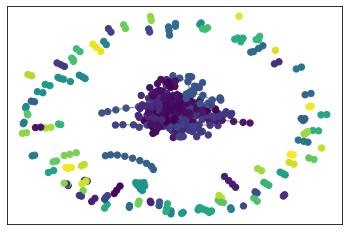

In [14]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

#first compute the best partition
partition = community_louvain.best_partition(G)

# compute the best partition
partition = community_louvain.best_partition(G)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [15]:
G = add_attributes(G,partition ,'community')

{'Nicki Minaj': 0,
 'Michael Bublé': 1,
 'XXXTENTACION': 2,
 'Kane Brown': 3,
 'Logic': 4,
 'Julia Michaels': 5,
 'Daya': 6,
 'Cheat Codes': 7,
 'The Greatest Showman Ensemble': 8,
 'John Williams': 9,
 'Chance the Rapper': 3,
 'Powfu': 10,
 'WizKid': 11,
 'Curtis Waters': 12,
 'FLETCHER': 13,
 'Zion': 0,
 'Mike Taylor': 14,
 'Arcangel': 15,
 'Chris Brown': 11,
 'Bad Bunny': 0,
 'Alan Walker': 15,
 'Ken Darby Singers': 16,
 'A7S': 17,
 'Becky Hill': 18,
 'Paul McCartney': 18,
 'Rod Wave': 11,
 'Clean Bandit': 4,
 'Sabrina Carpenter': 15,
 'All Time Low': 4,
 'Farruko': 15,
 'Yak Gotti': 2,
 'Kyla': 11,
 'Rex Orange County': 21,
 'Savage Ga$p': 22,
 'Maggie Lindemann': 7,
 'City Girls': 23,
 'Pharrell Williams': 24,
 'Emilee': 25,
 'A Great Big World': 26,
 'Trevor Daniel': 3,
 'Trippie Redd': 3,
 'Oh Wonder': 3,
 'Keala Settle': 8,
 'Alesso': 4,
 'Justin Quiles': 15,
 'Lost Sky': 27,
 'H.E.R.': 23,
 '明美圭一': 28,
 'Daft Punk': 24,
 'Ashe': 29,
 'El Alfa': 15,
 'Danna Paola': 30,
 'Nile R

## Salida a JSON

# Visualización D3.js